In [13]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch import nn
from torch.nn import functional as nnf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import itertools
from collections import defaultdict
import numpy as np

In [14]:
# data = pd.read_csv('mlp.csv')
# # data = data.sample(300, random_state=1)
# x = data['x'].to_numpy()
# y = data['y'].to_numpy()

# x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, random_state=1)

In [15]:
# data gen params
N = 128
var = 1
start = 0.01
end = 15
split = 0.5
seed = 42
np.random.seed(seed)
def f_x(x):
    return np.sin(x) + np.log(x)

# data
x = np.linspace(start, end, N)
y = f_x(x)
noise = np.random.normal(0, var,N)
y = y + noise
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=split, random_state=seed)



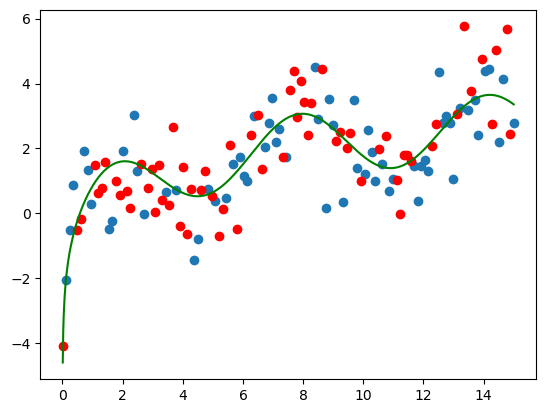

In [16]:
plt.scatter(x_train, y_train)
plt.scatter(x_val, y_val, c='red')
x_gt = np.linspace(start, end, 1000)
y_gt = f_x(x_gt)
plt.plot(x_gt, y_gt, color='green')

In [17]:
class ToyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [18]:
# class MLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.linear1 = nn.Linear(1, 28)
#         self.linear2 = nn.Linear(1, 56)
#         self.linear2 = nn.Linear(1, 56)

# [64, 128, 256, 512, 256, 128, 64]


#     def forward(self, x):
#         return self.layers(x)

In [19]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, dropout_ratio=0.1):
        super().__init__()

        modules = []
        for i in range(len(layer_sizes)-1):
            modules.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            if not i == len(layer_sizes)-2:
                modules.append(nn.ReLU())
                modules.append(nn.Dropout(dropout_ratio))

        self.layers = nn.Sequential(*modules)


    def forward(self, x):
        return self.layers(x)

In [33]:
def train(model, trainloader, valloader, optimizer, epochs, device, savepath_best_statedict=None):
    train_losses = []
    val_losses = []
    min_val_loss = float('inf')
    model.train()

    for _ in tqdm(range(epochs)):
        train_loss = train_one_epoch(model, trainloader, optimizer, device)
        train_losses.append(train_loss)

        val_loss = validate(model, valloader, device)
        val_losses.append(val_loss)

        if savepath_best_statedict is not None:
            if val_loss < min_val_loss:
                torch.save(model.state_dict(), savepath_best_statedict)
                min_val_loss = val_loss
    return train_losses, val_losses

def train_one_epoch(model, trainloader, optimizer, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in trainloader:
        x_batch = x_batch[:, None].float().to(device)
        y_batch = y_batch[:, None].float().to(device)
        y_pred = model(x_batch)

        optimizer.zero_grad()
        loss = nnf.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(trainloader)

def validate(model, valloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch = x_batch[:, None].float().to(device)
            y_batch = y_batch[:, None].float().to(device)
            y_pred = model(x_batch)
            loss = nnf.mse_loss(y_pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(valloader)

In [293]:
# dropout_ratio = 0.5
# base_layer_sizes = [64, 128, 256, 128, 64]
# multiplier = 1
# layer_sizes = [1] + [multiplier * layer_size for layer_size in base_layer_sizes] + [1]
# model = MLP(layer_sizes=layer_sizes, dropout_ratio=dropout_ratio).to(device)

In [24]:
trainset = ToyDataset(x_train, y_train)
valset = ToyDataset(x_val, y_val)
trainloader = DataLoader(trainset, batch_size=int(N/2), shuffle=True)
valloader = DataLoader(valset, batch_size=int(N/2), shuffle=False)

In [ ]:
# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model is running on {device}.")
epochs = 5000
lr = 0.01
experimental_results = defaultdict(list)

# hyperparameters to vary
dropout_ratios = [0, 0.1, 0.3, 0.6]
weight_decays = [0, 0.1, 0.01, 0.001]
hidden_layer_sizes = [[64, 128, 256, 128, 64],
               [28, 56, 112, 56, 28],
               [14, 28, 56, 28, 14],]
parameter_combinations = itertools.product(dropout_ratios, weight_decays, hidden_layer_sizes)

for combination in tqdm(parameter_combinations):
    dropout_ratio = combination[0]
    weight_decay = combination[1]
    layer_sizes = combination[2]
    experimental_results['dropout_ratio'].append(dropout_ratio)
    experimental_results['weight_decay'].append(weight_decay)
    experimental_results['layer_sizes'].append(layer_sizes)

    layer_sizes = [1] + layer_sizes + [1]
    model = MLP(layer_sizes=layer_sizes, dropout_ratio=dropout_ratio).to(device)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = train(model, trainloader, valloader, optimizer, epochs, device)
    experimental_results['min_val_loss'].append(np.min(val_losses))

    experimental_results_df = pd.DataFrame.from_dict(experimental_results)
    experimental_results_df.to_pickle('/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/experimental_results.pkl')


In [ ]:
plt.scatter(x_train, y_train)

x_seq = torch.linspace(start, end, 1000)[:, None].to(device)
model.eval()
with torch.no_grad():
    y_seq = model(x_seq)
plt.plot(x_seq.cpu(), y_seq.cpu(), c='r')

In [12]:
test = pd.read_pickle('/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/experimental_results.pkl')
test.iloc[test['min_val_loss'].argmin(), :]

dropout_ratio                      0.0
weight_decay                     0.001
layer_sizes      [28, 56, 112, 56, 28]
min_val_loss                  1.216197
Name: 10, dtype: object

# train best model

In [34]:
# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model is running on {device}.")
epochs = 5000
lr = 0.01
experimental_results = defaultdict(list)

# hyperparameters to vary
dropout_ratio = 0
weight_decay = 0.001
layer_sizes = [28, 56, 112, 56, 28]
layer_sizes = [1] + layer_sizes + [1]

model = MLP(layer_sizes=layer_sizes, dropout_ratio=dropout_ratio).to(device)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses, val_losses = train(model, trainloader, valloader, optimizer, epochs, device, savepath_best_statedict='/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/best_model.pth')

The model is running on cuda.


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:20<00:00, 241.88it/s]


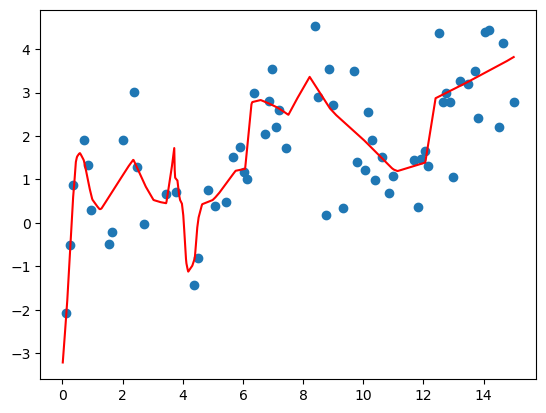

In [36]:
plt.scatter(x_train, y_train)

x_seq = torch.linspace(start, end, 1000)[:, None].to(device)
model.load_state_dict(torch.load('/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/best_model.pth'))
model.eval()
with torch.no_grad():
    y_seq = model(x_seq)
plt.plot(x_seq.cpu(), y_seq.cpu(), c='r')